# HARDWARE

## Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

"""
To change attributes:
1) Change ATTRIBUTE and you're good to go
"""
ATTRIBUTE = 'polarity'
COUNTER = '_new'
PARALLEL = 4
PARALLEL_F = 10
PARALLEL_EXTRACTION = 8
TRAIN_SIZE = 25
DEV_SIZE = 25
TEST_SIZE = 25

import os
import sys

os.environ['SNORKELDBNAME'] = ATTRIBUTE + str(COUNTER) +'2'
os.environ['SNORKELDB'] = 'postgres://localhost:5432/'# + os.environ['SNORKELDBNAME']
        
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/fonduer/tables/')
snorkel_postgres = os.environ['SNORKELDB'].startswith('postgres')
print snorkel_postgres

/Users/sen/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1085: UserWarning: Duplicate key in file "/Users/sen/.matplotlib/matplotlibrc", line #467
  (fname, cnt))


True


In [2]:
import os
if snorkel_postgres:
#     os.environ['SNORKELDBNAME'] = ATTRIBUTE + str(COUNTER) +'2'
    print os.system("dropdb " + os.environ['SNORKELDBNAME'])
    print os.system("createdb " + os.environ['SNORKELDBNAME'])
    print "SNORKELDBNAME = %s" % os.environ['SNORKELDBNAME']
else:
    try:
        os.remove('snorkel.db')
    except:
        pass

from fonduer import SnorkelSession
session = SnorkelSession()

256
0
SNORKELDBNAME = polarity_new2


## Parsing

In [3]:
import os
if snorkel_postgres:
    from fonduer.async_parser import HTMLParser, AsyncOmniParser
    print "Starting async parse..."
    
    doc_preprocessor = HTMLParser()
    corpus_parser = AsyncOmniParser(blacklist=['style'], flatten=['span','br'], 
                                     tabular=True, lingual=True,
                                     visual=True)
    # PARSE TRAIN
    corpus_name = 'Hardware Train'
    docs_path = os.environ['SNORKELHOME'] + '/tutorials/fonduer/tables/data/hardware/train_digikey/html/'
    pdf_path = os.environ['SNORKELHOME'] + '/tutorials/fonduer/tables/data/hardware/train_digikey/pdf/'

    %time corpus = corpus_parser.apply(doc_preprocessor, docs_path, pdf_path, session, corpus_name,\
                                max_docs=TRAIN_SIZE, parallel=PARALLEL)
    print "%s contains %d documents" % (corpus, len(corpus))
    session.commit()
    # PARSE DEV
    corpus_name = 'Hardware Dev'
    docs_path = os.environ['SNORKELHOME'] + '/tutorials/fonduer/tables/data/hardware/dev/html/'
    pdf_path = os.environ['SNORKELHOME'] + '/tutorials/fonduer/tables/data/hardware/dev/pdf/'
    
    %time corpus = corpus_parser.apply(doc_preprocessor, docs_path, pdf_path, session, corpus_name,\
                                max_docs=DEV_SIZE, parallel=PARALLEL)
    print "%s contains %d documents" % (corpus, len(corpus))
    session.commit()
    if TEST_SIZE:
        # PARSE TEST
        corpus_name = 'Hardware Test'
        docs_path = os.environ['SNORKELHOME'] + '/tutorials/fonduer/tables/data/hardware/test/html/'
        pdf_path = os.environ['SNORKELHOME'] + '/tutorials/fonduer/tables/data/hardware/test/pdf/'
        
        %time corpus = corpus_parser.apply(doc_preprocessor, docs_path, pdf_path, session, corpus_name,\
                                    max_docs=TEST_SIZE, parallel=PARALLEL)
        print "%s contains %d documents" % (corpus, len(corpus))
        session.commit()

Starting async parse...
[========================================] 100%
CPU times: user 142 ms, sys: 42 ms, total: 184 ms
Wall time: 28.1 s
Corpus (Hardware Train) contains 25 documents
[========================================] 100%
CPU times: user 75.5 ms, sys: 39.1 ms, total: 115 ms
Wall time: 1min 3s
Corpus (Hardware Dev) contains 24 documents
[========================================] 100%
CPU times: user 71.2 ms, sys: 38.6 ms, total: 110 ms
Wall time: 49 s
Corpus (Hardware Test) contains 25 documents


### Save Corpus

In [4]:
# If necessary
if not snorkel_postgres:
    import os
    os.system('cp snorkel.db snorkel.db\ corpus');

## Extraction

In [5]:
# # If necessary:
# import os
# os.remove('snorkel.db');
# os.system('cp snorkel.db\ corpus snorkel.db');

# import sys
# sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

# from snorkel import SnorkelSession
# session = SnorkelSession()

In [6]:
from fonduer.models import candidate_subclass

Part_Attr = candidate_subclass('Part_Attr', ['part','attr'])

In [7]:
# session.rollback()

### Define Matchers

In [8]:
from hardware_matchers import get_matcher

dict_path = os.environ['SNORKELHOME'] +\
    '/tutorials/fonduer/tables/data/hardware/gold_raw/digikey_part_dictionary.csv'
part_matcher = get_matcher('part', dict_path)
attr_matcher = get_matcher(ATTRIBUTE)

Using combined matcher.


### Define ContextSpaces

In [9]:
from hardware_spaces import get_space
    
part_ngrams = get_space('part')
attr_ngrams = get_space(ATTRIBUTE)

### Define Candidate Throttler

In [10]:
from hardware_throttlers import get_throttler

throttler = get_throttler(ATTRIBUTE)
# throttler = None
print throttler

<function polarity_throttler at 0x112ccf0c8>


### Run CandidateExtractor

In [11]:
from fonduer.models import Corpus
from fonduer.candidates import CandidateExtractor
from snorkel.utils import get_ORM_instance
from fonduer.async_candidates import parallel_extract

candidate_extractor = CandidateExtractor(Part_Attr, 
                        [part_ngrams, attr_ngrams], 
                        [part_matcher, attr_matcher], 
                        throttler=throttler)

corpus_names = ['Hardware Train', 'Hardware Dev']
if TEST_SIZE:
    corpus_names.append('Hardware Test')
for corpus_name in corpus_names:
    corpus = get_ORM_instance(Corpus, session, corpus_name)
    print "Extracting Candidates from %s" % corpus
    %time candidates = parallel_extract(session, candidate_extractor, corpus, \
                                        corpus_name + ' Candidates', \
                                        parallel=PARALLEL_EXTRACTION)
    session.add(candidates)
    print "%s contains %d Candidates" % (candidates, len(candidates))
session.commit()

Extracting Candidates from Corpus (Hardware Train)
[========================================] 100%
CPU times: user 64.7 ms, sys: 48.1 ms, total: 113 ms
Wall time: 9.23 s
Candidate Set (Hardware Train Candidates) contains 1375 Candidates
Extracting Candidates from Corpus (Hardware Dev)
[========================================] 100%
CPU times: user 108 ms, sys: 65.5 ms, total: 173 ms
Wall time: 1min 6s
Candidate Set (Hardware Dev Candidates) contains 4977 Candidates
Extracting Candidates from Corpus (Hardware Test)
[========================================] 100%
CPU times: user 99.2 ms, sys: 61.2 ms, total: 160 ms
Wall time: 1min 5s
Candidate Set (Hardware Test Candidates) contains 3490 Candidates


### Second Pass

In [12]:
# from hardware_utils import get_gold_parts_by_doc, get_manual_parts_by_doc
# from snorkel.utils import get_ORM_instance
# from snorkel.models import Corpus

# corpus = get_ORM_instance(Corpus, session, 'Hardware Dev')

# # parts_by_doc = get_gold_parts_by_doc()
# parts_by_doc = get_manual_parts_by_doc(corpus.documents.all())
# # parts_by_doc = None

In [13]:
# import cPickle as pickle
# pickle_file = os.environ['SNORKELHOME'] + '/tutorials/tables/sandbox/parts_by_doc_dev.pkl'

# with open(pickle_file, 'w') as f:
#     pickle.dump(parts_by_doc, f)

In [14]:
import cPickle as pickle
pickle_file = os.environ['SNORKELHOME'] + '/tutorials/fonduer/tables/sandbox/parts_by_doc_dev.pkl'
with open(pickle_file, 'r') as f:
    parts_by_doc = pickle.load(f)

### Assess Recall

In [15]:
from fonduer.models import Corpus, CandidateSet
from hardware_utils import entity_level_f1

corpus = get_ORM_instance(Corpus, session, 'Hardware Dev')
candidates = get_ORM_instance(CandidateSet, session, 'Hardware Dev Candidates')
gold_file = os.environ['SNORKELHOME'] + \
    '/tutorials/fonduer/tables/data/hardware/dev/hardware_dev_gold.csv'
%time (ctp, cfp, cfn) = entity_level_f1(candidates, gold_file, ATTRIBUTE, corpus, parts_by_doc)

Preparing candidates...
[========================================] 100%
Scoring on Entity-Level Gold Data
Corpus Precision 0.923
Corpus Recall    0.978
Corpus F1        0.949
----------------------------------------
TP: 310 | FP: 26 | FN: 7

CPU times: user 7.13 s, sys: 348 ms, total: 7.48 s
Wall time: 8.71 s


In [16]:
from pprint import pprint
pprint(cfp)

[(u'2N6427', u'MPSA14', u'NPN'),
 (u'BC337', u'BC33740BU', u'NPN'),
 (u'BC337', u'BC338-16', u'NPN'),
 (u'BC337', u'BC338-40', u'NPN'),
 (u'BC337-D', u'BC337-XX', u'NPN'),
 (u'BC546-BC548C(TO-92)', u'BC546-BC548C', u'NPN'),
 (u'BC546_DIOTEC', u'BC546', u'PNP'),
 (u'BC546_DIOTEC', u'BC546A', u'PNP'),
 (u'BC546_DIOTEC', u'BC546B', u'PNP'),
 (u'BC546_DIOTEC', u'BC546C', u'NPN'),
 (u'BC546_DIOTEC', u'BC546C', u'PNP'),
 (u'BC546_DIOTEC', u'BC547', u'PNP'),
 (u'BC546_DIOTEC', u'BC547A', u'PNP'),
 (u'BC546_DIOTEC', u'BC547B', u'PNP'),
 (u'BC546_DIOTEC', u'BC547C', u'PNP'),
 (u'BC546_DIOTEC', u'BC548', u'PNP'),
 (u'BC546_DIOTEC', u'BC548A', u'PNP'),
 (u'BC546_DIOTEC', u'BC548B', u'PNP'),
 (u'BC546_DIOTEC', u'BC548C', u'PNP'),
 (u'BC546_DIOTEC', u'BC549', u'PNP'),
 (u'BC546_DIOTEC', u'BC549A', u'NPN'),
 (u'BC546_DIOTEC', u'BC549A', u'PNP'),
 (u'BC546_DIOTEC', u'BC549B', u'PNP'),
 (u'BC546_DIOTEC', u'BC549C', u'PNP'),
 (u'BC547', u'BC548BU', u'NPN'),
 (u'BC818-40LT1-D', u'BC818-40LT1', u'NPN')]


In [17]:
pprint(cfn)

[('BOURNSINC_BD246BS', 'BD246', 'PNP'),
 ('BOURNSINC_BD246BS', 'BD246A', 'PNP'),
 ('BOURNSINC_BD246BS', 'BD246B', 'PNP'),
 ('BOURNSINC_BD246BS', 'BD246C', 'PNP'),
 ('BOURNSINC_TIP152S', 'TIP150', 'NPN'),
 ('BOURNSINC_TIP152S', 'TIP151', 'NPN'),
 ('BOURNSINC_TIP152S', 'TIP152', 'NPN')]


In [18]:
# If necessary
if not snorkel_postgres:
    import os
    os.system('cp snorkel.db snorkel.db\ candidates');

## Gold Labels

In [19]:
# If necessary
# import os
# os.remove('snorkel.db');
# os.system('cp snorkel.db\ candidates snorkel.db');

# import sys
# sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

# from snorkel import SnorkelSession
# session = SnorkelSession()

# from snorkel.models import candidate_subclass
# Part_Attr = candidate_subclass('Part_Attr', ['part','attr'])

In [20]:
import os
from fonduer.models import CandidateSet
from hardware_utils import load_hardware_labels

data_sets = ['Dev']
gold_file = {}
gold_file['Dev'] = os.environ['SNORKELHOME'] + '/tutorials/fonduer/tables/data/hardware/dev/hardware_dev_gold.csv'
if TEST_SIZE:
    data_sets.append('Test')
    gold_file['Test'] = os.environ['SNORKELHOME'] + '/tutorials/fonduer/tables/data/hardware/test/hardware_test_gold.csv'
for data_set in data_sets:
    candidate_set_name = 'Hardware %s Candidates' % data_set
    candidates = session.query(CandidateSet).filter(
        CandidateSet.name == candidate_set_name).one()
    label_set_name = 'Hardware %s Candidates -- Gold' % data_set
    annotation_key_name = 'Hardware %s Labels -- Gold' % data_set
    %time gold_candidates, annotation_key = load_hardware_labels(session,\
                           label_set_name, \
                           annotation_key_name, \
                           candidates, \
                           gold_file[data_set], \
                           ATTRIBUTE)
    candidates_gold = session.query(CandidateSet).filter(
        CandidateSet.name == candidate_set_name + ' -- Gold').one()
    print "%d/%d Candidates in %s have positive Labels" % (
        len(candidates_gold), len(candidates), candidates)

Loading 4977 candidate labels
[========================================] 100%
CPU times: user 12.2 s, sys: 606 ms, total: 12.8 s
Wall time: 15.4 s
4915/4977 Candidates in Candidate Set (Hardware Dev Candidates) have positive Labels
Loading 3490 candidate labels
[========================================] 100%
CPU times: user 7.22 s, sys: 394 ms, total: 7.61 s
Wall time: 9.17 s
2961/3490 Candidates in Candidate Set (Hardware Test Candidates) have positive Labels


In [21]:
# If necessary
if not snorkel_postgres:
    import os
    os.system('cp snorkel.db snorkel.db\ labels');

## Features

In [22]:
# # If necessary:
# import os
# # os.remove('snorkel.db');
# os.system('cp snorkel.db\ labels snorkel.db');

# from snorkel import SnorkelSession
# session = SnorkelSession()

# from snorkel.models import candidate_subclass
# Part_Attr = candidate_subclass('Part_Attr', ['part','attr'])

### Extract Features

In [23]:
from fonduer.models import CandidateSet
from snorkel.utils import get_ORM_instance

train = get_ORM_instance(CandidateSet, session, 'Hardware Train Candidates')
dev   = get_ORM_instance(CandidateSet, session, 'Hardware Dev Candidates')
test  = get_ORM_instance(CandidateSet, session, 'Hardware Test Candidates')

if snorkel_postgres:
    from fonduer.async_annotations import annotate
    print "Starting async featurization..."
    %time F_train = annotate(train, parallel=PARALLEL_F, dynamic_scheduling=False)
    %time F_dev   = annotate(dev, parallel=PARALLEL_F, dynamic_scheduling=False,\
                             keyset = 'Hardware Train Candidates')
    if TEST_SIZE:
        %time F_test = annotate(test, parallel=PARALLEL_F, dynamic_scheduling=False,\
                                keyset = 'Hardware Train Candidates')
    
else:
    from fonduer.models import CandidateSet
    from fonduer.fast_annotations import FeatureManager
    from snorkel.utils import get_ORM_instance

    print "Starting sync featurization..."
    feature_manager = FeatureManager()
    %time F_train = feature_manager.create(session, train, 'Train Features')
    %time F_dev = feature_manager.update(session, dev, 'Train Features', expand_key_set=False)

Starting async featurization...
[========================================] 100%
Copying hardware_train_candidates_features to postgres
COPY 1375

CPU times: user 5.57 s, sys: 337 ms, total: 5.9 s
Wall time: 35.8 s
[========================================] 100%
Copying hardware_dev_candidates_features to postgres
COPY 4977

CPU times: user 4.7 s, sys: 293 ms, total: 5 s
Wall time: 4min 49s
[========================================] 100%
Copying hardware_test_candidates_features to postgres
COPY 3490

CPU times: user 3.34 s, sys: 214 ms, total: 3.55 s
Wall time: 5min 54s


In [24]:
# If necessary:
if not snorkel_postgres:
    import os
    os.system('cp snorkel.db snorkel.db\ featurized');

## LFs

In [25]:
# If necessary
# import os
# os.remove('snorkel.db');
# os.system('cp snorkel.db\ featurized snorkel.db');

# from snorkel import SnorkelSession
# session = SnorkelSession()

# import sys
# sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

# from snorkel.models import candidate_subclass
# Part_Attr = candidate_subclass('Part_Attr', ['part','attr'])

# from snorkel.models import CandidateSet
# train = session.query(CandidateSet).filter(
#     CandidateSet.name == 'Hardware Train Candidates').one()
# dev = session.query(CandidateSet).filter(
#     CandidateSet.name == 'Hardware Dev Candidates').one()

# from snorkel.annotations import FeatureManager, LabelManager
# feature_manager = FeatureManager()
# %time F_train = feature_manager.load(session, train, 'Train Features')
# %time F_dev = feature_manager.load(session, dev, 'Train Features')

### Define LFs

In [26]:
from hardware_lfs import get_lfs

LFs = get_lfs(ATTRIBUTE)

### Apply LFs

In [27]:
if snorkel_postgres:
    from fonduer.async_annotations import annotate
    %time L_train = annotate(train, parallel=PARALLEL_F, lfs=LFs, dynamic_scheduling=False)
else:
    from fonduer.fast_annotations import LabelManager
    label_manager = LabelManager()
    %time L_train = label_manager.create(session, train, 'LF Labels', f=LFs)
L_train

[========================================] 100%
Copying hardware_train_candidates_labels to postgres
COPY 1375

CPU times: user 442 ms, sys: 149 ms, total: 591 ms
Wall time: 14.8 s


<1375x12 sparse matrix of type '<type 'numpy.float32'>'
	with 3765 stored elements in Compressed Sparse Row format>

### Assess LF accuracy

In [28]:
%time L_train.lf_stats()

CPU times: user 4.47 ms, sys: 1.38 ms, total: 5.85 ms
Wall time: 5 ms


,conflicts,coverage,j,overlaps
LF_part_complement,0.000000,0.000000,0,0.000000
LF_polarity_complement,0.142545,1.000000,1,1.000000
LF_polarity_transistor_type,0.142545,1.000000,2,1.000000
LF_many_p_siblings,0.000000,0.000000,3,0.000000
LF_polarity_in_header_tag,0.142545,0.396364,4,0.396364
LF_polarity_right_of_part,0.030545,0.100364,5,0.100364
LF_replacement_table,0.000000,0.000000,6,0.000000
LF_both_present,0.000000,0.000000,7,0.000000
LF_please_to_left,0.000000,0.000000,8,0.000000
LF_polarity_part_tabular_align,0.000000,0.000000,9,0.000000


In [29]:
# If necessary
if not snorkel_postgres:
    import os
    os.system('cp snorkel.db snorkel.db\ features');

## Learn and Evaluate

In [30]:
# If necessary:
# import os
# os.remove('snorkel.db');
# os.system('cp snorkel.db\ features snorkel.db');

# from snorkel import SnorkelSession
# session = SnorkelSession()

# import sys
# sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

# from snorkel.models import candidate_subclass
# Part_Attr = candidate_subclass('Part_Attr', ['part','attr'])

# from snorkel.models import CandidateSet
# train = session.query(CandidateSet).filter(
#     CandidateSet.name == 'Hardware Training Candidates').one()
# dev = session.query(CandidateSet).filter(
#     CandidateSet.name == 'Hardware Development Candidates').one()

# from snorkel.annotations import FeatureManager, LabelManager
# feature_manager = FeatureManager()
# %time F_train = feature_manager.load(session, train, 'Train Features')
# %time F_dev = feature_manager.load(session, dev, 'Train Features')

# label_manager = LabelManager()
# %time L_train = label_manager.load(session, train, 'LF Labels')

In [31]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
%time gen_model.train(L_train, epochs=500, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=1e-6)

/Users/sen/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


CPU times: user 19.4 s, sys: 65.5 ms, total: 19.5 s
Wall time: 19.5 s


In [32]:
train_marginals = gen_model.marginals(L_train)

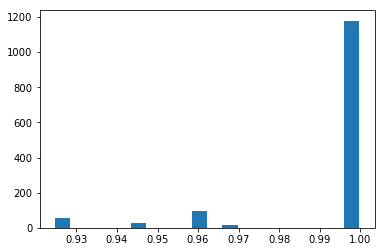

In [33]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [34]:
gen_model.weights.lf_accuracy()

array([ 0.51989872,  0.78474406,  0.86982355,  0.51718971,  0.65659073,
        0.55141557,  0.51467884,  0.52099708,  0.51829243,  0.51958109,
        0.57966534,  0.53871471])

In [35]:
# from snorkel.learning import NaiveBayes

# gen_model = NaiveBayes()
# %time gen_model.train(L_train, n_iter=2000, rate=1e-3, mu=1e-6)
# train_marginals = gen_model.marginals(L_train)

In [36]:
pprint(zip([lf.__name__ for lf in LFs], gen_model.weights.lf_accuracy_log_odds))
print min(train_marginals)
print max(train_marginals)

[('LF_replacement_table', 0.079636956467542638),
 ('LF_many_p_siblings', 1.2935299156891837),
 ('LF_part_complement', 1.8993995479168373),
 ('LF_please_to_left', 0.068785948508599773),
 ('LF_polarity_transistor_type', 0.64813795457280454),
 ('LF_polarity_part_tabular_align', 0.20639183390931873),
 ('LF_polarity_part_horz_align', 0.058732233162916495),
 ('LF_polarity_part_vert_align', 0.084037746490954343),
 ('LF_polarity_right_of_part', 0.073202401465787853),
 ('LF_polarity_in_header_tag', 0.078364439565124178),
 ('LF_polarity_complement', 0.32139971891295838),
 ('LF_both_present', 0.15516944253555273)]
0.924701806725
0.999757661886


In [37]:
from snorkel.learning import SparseLogisticRegression

disc_model = SparseLogisticRegression()
%time disc_model.train(F_train, train_marginals, n_epochs=200, lr=0.001)

[SparseLR] lr=0.001 l1=0.0 l2=0.0
[SparseLR] Building model
[SparseLR] Training model
[SparseLR] #examples=1375  #epochs=200  batch size=100
[SparseLR] Epoch 0 (0.41s)	Avg. loss=0.386224	NNZ=8442
[SparseLR] Epoch 5 (1.63s)	Avg. loss=0.053987	NNZ=8442
[SparseLR] Epoch 10 (2.80s)	Avg. loss=0.046882	NNZ=8442
[SparseLR] Epoch 15 (3.99s)	Avg. loss=0.044180	NNZ=8442
[SparseLR] Epoch 20 (5.24s)	Avg. loss=0.042648	NNZ=8442
[SparseLR] Epoch 25 (6.37s)	Avg. loss=0.041622	NNZ=8442
[SparseLR] Epoch 30 (7.53s)	Avg. loss=0.040882	NNZ=8442
[SparseLR] Epoch 35 (8.69s)	Avg. loss=0.040311	NNZ=8442
[SparseLR] Epoch 40 (9.93s)	Avg. loss=0.039850	NNZ=8442
[SparseLR] Epoch 45 (11.09s)	Avg. loss=0.039465	NNZ=8442
[SparseLR] Epoch 50 (12.25s)	Avg. loss=0.039137	NNZ=8442
[SparseLR] Epoch 55 (13.51s)	Avg. loss=0.038853	NNZ=8442
[SparseLR] Epoch 60 (14.65s)	Avg. loss=0.038606	NNZ=8442
[SparseLR] Epoch 65 (15.81s)	Avg. loss=0.038390	NNZ=8442
[SparseLR] Epoch 70 (16.96s)	Avg. loss=0.038199	NNZ=8442
[SparseLR] Epoc

In [38]:
# from snorkel.learning import LogReg

# disc_model = LogReg()
# %time disc_model.train(F_train, train_marginals, n_iter=10000, rate=1e-3)

In [39]:
dev_gold = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Dev Candidates -- Gold').one()

In [40]:
from fonduer.annotations import LabelManager
label_manager = LabelManager()
L_dev = label_manager.load(session, dev, 'Hardware Dev Labels -- Gold')
L_dev.shape

(4977, 1)

In [41]:
tp, fp, tn, fn = disc_model.score(session, F_dev, L_dev)

Scores (Un-adjusted)
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            0.988
Recall               1.0
F1                   0.994
----------------------------------------
TP: 4915 | FP: 62 | TN: 0 | FN: 0



In [42]:
from fonduer.models import Corpus
from hardware_utils import entity_level_f1
import os

gold_file = os.environ['SNORKELHOME'] + '/tutorials/fonduer/tables/data/hardware/dev/hardware_dev_gold.csv'
corpus = session.query(Corpus).filter(Corpus.name == 'Hardware Dev').one()
%time (TP, FP, FN) = entity_level_f1(tp.union(fp), gold_file, ATTRIBUTE, corpus, parts_by_doc=None)
%time (TP, FP, FN) = entity_level_f1(tp.union(fp), gold_file, ATTRIBUTE, corpus, parts_by_doc=parts_by_doc)

Preparing candidates...
[========================================] 100%
Scoring on Entity-Level Gold Data
Corpus Precision 0.965
Corpus Recall    0.868
Corpus F1        0.914
----------------------------------------
TP: 275 | FP: 10 | FN: 42

CPU times: user 8.28 s, sys: 476 ms, total: 8.76 s
Wall time: 10.3 s
Preparing candidates...
[========================================] 100%
Scoring on Entity-Level Gold Data
Corpus Precision 0.923
Corpus Recall    0.978
Corpus F1        0.949
----------------------------------------
TP: 310 | FP: 26 | FN: 7

CPU times: user 451 ms, sys: 140 ms, total: 591 ms
Wall time: 514 ms


### Error Analysis

### Oracle

In [44]:
from hardware_utils import get_gold_parts_by_doc, get_manual_parts_by_doc
from snorkel.utils import get_ORM_instance
from fonduer.models import Corpus

parts_by_doc = get_gold_parts_by_doc()
(TP, FP, FN) = entity_level_f1(tp.union(fp), gold_file, ATTRIBUTE, corpus, parts_by_doc)

Preparing candidates...
[========================================] 100%
Scoring on Entity-Level Gold Data
Corpus Precision 0.939
Corpus Recall    0.978
Corpus F1        0.958
----------------------------------------
TP: 310 | FP: 20 | FN: 7



### Test Results

In [45]:
if TEST_SIZE:
    from fonduer.annotations import LabelManager
    label_manager = LabelManager()
    L_test = label_manager.load(session, test, 'Hardware Test Labels -- Gold')
    L_test.shape
    
    tp, fp, tn, fn = disc_model.score(session, F_test, L_test, b=0.91)
    
    from hardware_utils import get_gold_parts_by_doc, get_manual_parts_by_doc
    from snorkel.utils import get_ORM_instance
    from fonduer.models import Corpus

    corpus = get_ORM_instance(Corpus, session, 'Hardware Test')

    # parts_by_doc_test = get_manual_parts_by_doc(corpus.documents.all())
    # parts_by_doc_test = None
    import cPickle as pickle
    pickle_file = os.environ['SNORKELHOME'] + '/tutorials/fonduer/tables/sandbox/parts_by_doc_test.pkl'
    with open(pickle_file, 'r') as f:
        parts_by_doc_test = pickle.load(f)

    from hardware_utils import entity_level_f1

    gold_file = os.environ['SNORKELHOME'] + '/tutorials/fonduer/tables/data/hardware/test/hardware_test_gold.csv'
    (TP, FP, FN) = entity_level_f1(tp.union(fp), gold_file, ATTRIBUTE, corpus)
    (TP, FP, FN) = entity_level_f1(tp.union(fp), gold_file, ATTRIBUTE, corpus, parts_by_doc_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.766
Neg. class accuracy: 0.817
Precision            0.959
Recall               0.766
F1                   0.852
----------------------------------------
TP: 2268 | FP: 97 | TN: 432 | FN: 693

Preparing candidates...
[========================================] 100%
Scoring on Entity-Level Gold Data
Corpus Precision 0.731
Corpus Recall    0.869
Corpus F1        0.794
----------------------------------------
TP: 106 | FP: 39 | FN: 16

Preparing candidates...
[========================================] 100%
Scoring on Entity-Level Gold Data
Corpus Precision 0.718
Corpus Recall    0.918
Corpus F1        0.806
----------------------------------------
TP: 112 | FP: 44 | FN: 10

